## Objectives

There is a company, which prepared special new offer for their customers. They have a dataset which consists information about their clients and how they reacted to the previous offers.

Your goal is to help them with current offer to provide list of customers who will accept new offer and also senior management would like to know why company should send them this new offer.

## Dataset, columns business meaning

### Target feature
- `accepted` - flag related whether customer accepted or not the offer

### Input features
- `offer_class` - previous offer class. e.g:
- `name` - hashed customer name
- `gender` - customer geneder
- `age` - age in years
- `phone_calls` - number of phone conversations with client during last quarter
- `emails` - number of emails sent to client during last 6 months
- `customer_code` - customer code
- `salary` - customer estimated salary
- `offer_code` - previous offer code
- `customer_type` - type of customer
- `number` - serial number of customer device
- `offer_value` - previous offers total value
- `estimated_expenses` - estimated expenses

In [153]:
import pandas as pd
import numpy as np
from scipy import stats
# conda install pyarrow -c conda-forge
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler

%matplotlib inline

## Load the data

In [71]:
df = pd.read_parquet('client_database.parquet', engine='pyarrow')

In [72]:
oryg_shape = df.shape
oryg_shape

(1309, 15)

- The dataset has 1309 rows (observations) and 15 columns (fetures).

In [73]:
df.head(6).T

,0,1,2,3,4,5
offer_class,Medium,Medium,Medium,Medium,Medium,Medium
accepted,yes,yes,no,no,no,yes
name,C7CBB5C5613449B,CFD09C0248BB417,A2A0DC541977473,9068458EB70D427,46F0CD19CF71429,060A000A1260427
gender,female,male,female,male,female,male
age,29,NaN,NaN,30,25,48
phone_calls,0,1,1,1,1,0
emails,0,2,3,2,2,0
customer_code,24160,113781,113781,113781,113781,19952
salary,21133.8,15155,15155,15155,15155,2655
offer_code,4AB,61A,DB4,9B6,191,62F


- There is a categorical feature `center` in the dataset which is not mentioned in the dataset description.

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 15 columns):
offer_class           1289 non-null object
accepted              1289 non-null object
name                  1289 non-null object
gender                1289 non-null object
age                   877 non-null float64
phone_calls           1286 non-null float64
emails                1287 non-null float64
customer_code         1265 non-null object
salary                1281 non-null float64
offer_code            1287 non-null object
customer_type         1287 non-null object
number                1280 non-null object
offer_value           1277 non-null float64
estimated_expenses    1286 non-null float64
center                1306 non-null object
dtypes: float64(6), object(9)
memory usage: 163.6+ KB


- There are 2 types of data: float64 and strings
- There are missing values in the dataset with `age` having most of them

In [75]:
#features_to_remove = []

In [76]:
print(df.groupby('accepted').size())

accepted
no     800
yes    489
dtype: int64


- The dataset is slightly imballanced.
- 

### Numerical features

In [77]:
df_num = df.select_dtypes(include = ['float64'])
df_num.head()

,age,phone_calls,emails,salary,offer_value,estimated_expenses
0,29.0,0.0,0.0,21133.75,57.426571,4692.0
1,NaN,1.0,2.0,15155.00,141.639912,3164.0
2,NaN,1.0,3.0,15155.00,154.821130,1852.0
3,30.0,1.0,2.0,15155.00,106.256196,3753.0
4,25.0,1.0,2.0,15155.00,139.237147,2410.0


In [78]:
df_num.describe()

,age,phone_calls,emails,salary,offer_value,estimated_expenses
count,877.000000,1286.000000,1287.000000,1281.000000,1277.000000,1286.000000
mean,33.511973,0.497667,0.881896,3297.296011,128.693732,4576.947900
std,12.247058,1.041360,1.022320,5034.240427,57.677807,1909.458459
min,18.000000,0.000000,0.000000,0.000000,50.022619,1257.000000
25%,24.000000,0.000000,0.000000,789.580000,82.632085,2934.750000
50%,30.000000,0.000000,1.000000,1445.420000,118.645478,4544.000000
75%,41.000000,1.000000,1.000000,3127.500000,162.482961,6225.750000
max,80.000000,8.000000,10.000000,51232.920000,368.668534,7891.000000


In [79]:
df_num[df_num.phone_calls == 0].count()

age                   617
phone_calls           877
emails                877
salary                873
offer_value           868
estimated_expenses    876
dtype: int64

In [80]:
df_num[df_num.salary == 0].count()

age                    8
phone_calls           17
emails                17
salary                17
offer_value           17
estimated_expenses    17
dtype: int64

In [81]:
df_num[df_num.offer_value == 0].count()

age                   0
phone_calls           0
emails                0
salary                0
offer_value           0
estimated_expenses    0
dtype: int64

In [82]:
n = len(df_num)
for column in df_num:    
    n_unique = len(df_num[column].unique())
    print('Feature: {}'.format(column))
    print('Enique values count: {}'.format(n_unique))
    print('Unique values ratio: {}'.format(n_unique / n))
    print('Missing values ratio: {}'.format(df_num[column].isnull().sum() / n))
    print('Median: {}'.format(df_num[column].median()))
    print('------------------------------------')
    
    print()

Feature: age
Enique values count: 73
Unique values ratio: 0.05576776165011459
Missing values ratio: 0.3300229182582124
Median: 30.0
------------------------------------

Feature: phone_calls
Enique values count: 8
Unique values ratio: 0.006111535523300229
Missing values ratio: 0.01757066462948816
Median: 0.0
------------------------------------

Feature: emails
Enique values count: 11
Unique values ratio: 0.008403361344537815
Missing values ratio: 0.01680672268907563
Median: 1.0
------------------------------------

Feature: salary
Enique values count: 282
Unique values ratio: 0.21543162719633308
Missing values ratio: 0.0213903743315508
Median: 1445.42
------------------------------------

Feature: offer_value
Enique values count: 1278
Unique values ratio: 0.9763177998472116
Missing values ratio: 0.024446142093200916
Median: 118.6454777
------------------------------------

Feature: estimated_expenses
Enique values count: 1186
Unique values ratio: 0.906035141329259
Missing values ratio

- There are 6 numerical features.
- The range of their values needs to be standardized.
- There are no kids represented in the dataset (min. age is 18). 25% of customers is 24 years old or below. Next 25% are customers of age 25-30. Next 25% of customers is up to 41 years old, and last 25% of customers are 42-80.
- There were 2-8 phone calls made only to 25% of customers. The rest got 0 or 1.
- 50% of customers got 0 or 1 email, 25% of customers got 2-10 emails.
- The min. salary is 0, median 1445.42 and max. 51232.
- The previous offers values range between 50 and 368 with the median of 119.
- Estimated expenses values range between 1257 and 7891 with the median of 4544.

In [83]:
# !!!!! missing values?

### Categorical Features

In [84]:
#list(set(df.dtypes.tolist()))
#df_cat = df.select_dtypes(include = ['O'])

In [85]:
df_cat = df[list(set(df.columns) - set(df_num.columns))]
df_cat.head()

,name,center,number,offer_code,customer_type,gender,offer_class,accepted,customer_code
0,C7CBB5C5613449B,A,9E9FA,4AB,S,female,Medium,yes,24160
1,CFD09C0248BB417,A,1E53D,61A,S,male,Medium,yes,113781
2,A2A0DC541977473,A,1.36E+06,DB4,S,female,Medium,no,113781
3,9068458EB70D427,B,F6529,9B6,S,male,Medium,no,113781
4,46F0CD19CF71429,A,E2FDF,191,S,female,Medium,no,113781


In [86]:
#feature_unique_values = {}
n = len(df_cat)
for column in df_cat:
    n_unique = len(df_cat[column].unique())
    #feature_unique_values[column] = n_unique
    print('---------------------')
    print('Feature name: {}'.format(column))
    print('Unique values count (including NaN): {}'.format(n_unique))
    if n_unique <= 5:
        print('Most frequent values:')
        print(df_cat.groupby(column).size())
    print('Variability ratio: {}'.format(n_unique / n))
    print('Values count (not null): {}'.format(df_cat[column].notnull().sum()))
    print('Values count (null): {}'.format(df_cat[column].isnull().sum()))
    print('Missing values ratio: {}'.format(df_cat[column].isnull().sum() / n))
    print()

---------------------
Feature name: name
Unique values count (including NaN): 1290
Variability ratio: 0.985485103132162
Values count (not null): 1289
Values count (null): 20
Missing values ratio: 0.015278838808250574

---------------------
Feature name: center
Unique values count (including NaN): 3
Most frequent values:
center
A    603
B    703
dtype: int64
Variability ratio: 0.002291825821237586
Values count (not null): 1306
Values count (null): 3
Missing values ratio: 0.002291825821237586

---------------------
Feature name: number
Unique values count (including NaN): 1280
Variability ratio: 0.9778456837280367
Values count (not null): 1280
Values count (null): 29
Missing values ratio: 0.02215431627196333

---------------------
Feature name: offer_code
Unique values count (including NaN): 1102
Variability ratio: 0.8418640183346066
Values count (not null): 1287
Values count (null): 22
Missing values ratio: 0.01680672268907563

---------------------
Feature name: customer_type
Unique va

- I will remove `number`, `name`, `offer_code`, `customer_code` from features list as these are kind of ID
- ??? what to do with `customer_code`, how to encode 900 different values?

In [87]:
#df_cat.hist(figsize=(22, 15), grid=True, bins=50);
df.head()

,offer_class,accepted,name,gender,age,phone_calls,emails,customer_code,salary,offer_code,customer_type,number,offer_value,estimated_expenses,center
0,Medium,yes,C7CBB5C5613449B,female,29.0,0.0,0.0,24160,21133.75,4AB,S,9E9FA,57.426571,4692.0,A
1,Medium,yes,CFD09C0248BB417,male,NaN,1.0,2.0,113781,15155.00,61A,S,1E53D,141.639912,3164.0,A
2,Medium,no,A2A0DC541977473,female,NaN,1.0,3.0,113781,15155.00,DB4,S,1.36E+06,154.821130,1852.0,A
3,Medium,no,9068458EB70D427,male,30.0,1.0,2.0,113781,15155.00,9B6,S,F6529,106.256196,3753.0,B
4,Medium,no,46F0CD19CF71429,female,25.0,1.0,2.0,113781,15155.00,191,S,E2FDF,139.237147,2410.0,A


In [114]:
#features_to_remove.append(['number', 'name'])
df.drop(columns=['number', 'name', 'offer_code', 'customer_code'], inplace=True)
#df.drop(columns=['customer_code'], inplace=True)
#features_to_remove = []
#features_to_remove

In [89]:
# Remove temporary datasets
#del df_cat, df_num

###### link czy wartosc? gdy tworzymy nowy dataset?

In [90]:
df.head()

,offer_class,accepted,gender,age,phone_calls,emails,customer_code,salary,customer_type,offer_value,estimated_expenses,center
0,Medium,yes,female,29.0,0.0,0.0,24160,21133.75,S,57.426571,4692.0,A
1,Medium,yes,male,NaN,1.0,2.0,113781,15155.00,S,141.639912,3164.0,A
2,Medium,no,female,NaN,1.0,3.0,113781,15155.00,S,154.821130,1852.0,A
3,Medium,no,male,30.0,1.0,2.0,113781,15155.00,S,106.256196,3753.0,B
4,Medium,no,female,25.0,1.0,2.0,113781,15155.00,S,139.237147,2410.0,A


### Missing values

In [91]:
def extract_columns_with_nans(df):
    columns_with_nans = df.isnull().sum()[df.isnull().sum() > 0]
    dic_nan = {'nans_count': columns_with_nans.values, 'percent': np.round(columns_with_nans.values * 100 / df.shape[0], 2)}
    df_nan = pd.DataFrame(data=dic_nan, index=columns_with_nans.index)
    df_nan.sort_values(by='percent', ascending=False, inplace=True)
    return df_nan

In [92]:
# Missing values by column
df_nan = extract_columns_with_nans(df)
df_nan

,nans_count,percent
age,432,33.00
customer_code,44,3.36
offer_value,32,2.44
salary,28,2.14
phone_calls,23,1.76
estimated_expenses,23,1.76
emails,22,1.68
customer_type,22,1.68
offer_class,20,1.53
accepted,20,1.53


In [93]:
# Missing values by row
missing_data_by_row = df.isnull().sum(axis=1)
missing_data_by_row.describe()

count    1309.000000
mean        0.526356
std         1.399634
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        11.000000
dtype: float64

- 25% of rows have between 1 and 14 missing values.
- `age`, `offer_value`, `salary`, `phone_calls`, `estimated_expenses`, `emails` - NaNs will be filled with the median.
- `customer_code` - I will remove 44 rows with NaNs as I do not know how to deal with missing values and leaving them as additional category, would skew the original distribution.
- I will remove rows with `center` (3), `offer_code` (2) and `customer_type' (2)

In [94]:
#df.customer_type.value_counts()

In [95]:
# Replace age, offer_value NaN with the feature median
df[['age']] = df[['age']].fillna(df.median())
df[['offer_value']] = df[['offer_value']].fillna(df.median())
df[['salary']] = df[['salary']].fillna(df.median())
df[['phone_calls']] = df[['phone_calls']].fillna(df.median())
df[['estimated_expenses']] = df[['estimated_expenses']].fillna(df.median())
df[['emails']] = df[['emails']].fillna(df.median())

In [96]:
#df.loc[df['customer_code'].isna()]
#df.loc[df['column_name'].isin(some_values)]

In [97]:
df_nan = extract_columns_with_nans(df)
df_nan

,nans_count,percent
customer_code,44,3.36
customer_type,22,1.68
offer_class,20,1.53
accepted,20,1.53
gender,20,1.53
center,3,0.23


In [98]:
df[df.customer_code.isna()]

,offer_class,accepted,gender,age,phone_calls,emails,customer_code,salary,customer_type,offer_value,estimated_expenses,center
69,Medium,no,male,30.0,0.0,0.0,None,0.00,S,111.165165,2077.0,B
78,Medium,yes,female,55.0,2.0,0.0,None,2570.00,S,141.671725,4666.0,A
238,Medium,no,male,31.0,0.0,0.0,None,5049.58,S,94.017023,6535.0,B
339,High,yes,female,30.0,2.0,1.0,None,3900.00,S,65.646576,1962.0,A
405,High,no,male,18.0,0.0,0.0,None,1050.00,S,71.000387,2940.0,A
466,High,yes,female,45.0,0.0,1.0,None,1350.00,S,155.645549,3849.0,B
515,High,yes,female,29.0,0.0,0.0,None,1050.00,S,56.912762,3235.0,A
576,High,yes,female,30.0,0.0,1.0,None,1575.00,S,231.888356,3207.0,B
631,Premium,no,male,35.0,0.0,0.0,None,705.00,S,101.855806,7326.0,B
642,Premium,no,male,23.0,0.0,0.0,None,705.00,S,94.696626,6896.0,B


In [99]:
#df2 = df.copy()

In [100]:
#df[df.customer_code.isna()]

In [101]:
# Abandon rows where there is NaN in the customer_code column
df = df[~df.customer_code.isna()]

In [102]:
#df[df.offer_value.isna()]

,offer_class,accepted,gender,age,phone_calls,emails,customer_code,salary,customer_type,offer_value,estimated_expenses,center


In [103]:
#df2 = df2.dropna()
#df2.customer_code.dropna(inplace=True)
#df2 = df2[np.isfinite(df['customer_code'])]
df_nan = extract_columns_with_nans(df)
df_nan

,nans_count,percent
center,3,0.24
customer_type,2,0.16


In [105]:
#df2.drop(['name'], axis=1)
# Abandon rows where there is NaN in the center, offer_code and customer_type columns
df = df[~df.center.isna()]
#df = df[~df.offer_code.isna()]
df = df[~df.customer_type.isna()]

In [ ]:
#nans = lambda df: df[df.isnull().any(axis=1)]
#nans(df)

In [106]:
df_nan = extract_columns_with_nans(df)
df_nan

,nans_count,percent


In [107]:
clean_shape = df.shape
clean_shape

(1260, 12)

In [108]:
# Initial & complete dataset comparison
num_removed_cols = oryg_shape[1] - clean_shape[1]
num_removed_cols_ratio = np.around(num_removed_cols * 100 / oryg_shape[1], 2)
num_removed_rows = oryg_shape[0] - clean_shape[0]
num_removed_rows_ratio = np.around(num_removed_rows * 100 / oryg_shape[0], 2)
print('Number (percent) of removed features: {} ({}%)'.format(num_removed_cols, num_removed_cols_ratio))
print('Number (percent) of removed observations (with NaNs): {} ({}%)'.format(num_removed_rows, num_removed_rows_ratio))

Number (percent) of removed features: 3 (20.0%)
Number (percent) of removed observations (with NaNs): 49 (3.74%)


In [109]:
df.head()

,offer_class,accepted,gender,age,phone_calls,emails,customer_code,salary,customer_type,offer_value,estimated_expenses,center
0,Medium,yes,female,29.0,0.0,0.0,24160,21133.75,S,57.426571,4692.0,A
1,Medium,yes,male,30.0,1.0,2.0,113781,15155.00,S,141.639912,3164.0,A
2,Medium,no,female,30.0,1.0,3.0,113781,15155.00,S,154.821130,1852.0,A
3,Medium,no,male,30.0,1.0,2.0,113781,15155.00,S,106.256196,3753.0,B
4,Medium,no,female,25.0,1.0,2.0,113781,15155.00,S,139.237147,2410.0,A


### Encode categorical features

In [117]:
df_cat = df[list(set(df.columns) - set(df_num.columns))]
df_cat.head()

,center,customer_type,gender,offer_class,accepted
0,A,S,female,Medium,yes
1,A,S,male,Medium,yes
2,A,S,female,Medium,no
3,B,S,male,Medium,no
4,A,S,female,Medium,no


In [119]:
cat_binary = []
cat_multi = []
for feature in df_cat:
    if df_cat[feature].nunique() > 2:
        cat_multi.append(feature)
    else:
        cat_binary.append(feature)

In [120]:
cat_binary

['center', 'gender', 'accepted']

In [121]:
cat_multi

['customer_type', 'offer_class']

In [123]:
# Encode binary features
for column in cat_binary:
    print(df_cat[column].value_counts())

B    680
A    580
Name: center, dtype: int64
male      813
female    447
Name: gender, dtype: int64
no     783
yes    477
Name: accepted, dtype: int64


In [125]:
df['center'].replace(['B', 'A'], [1, 0], inplace=True)
df['gender'].replace(['male', 'female'], [1, 0], inplace=True)
df['accepted'].replace(['yes', 'no'], [1, 0], inplace=True)

In [128]:
df_cat = df[list(set(df.columns) - set(df_num.columns))]
df_cat.head()

,center,customer_type,gender,offer_class,accepted
0,0,S,0,Medium,1
1,0,S,1,Medium,1
2,0,S,0,Medium,0
3,1,S,1,Medium,0
4,0,S,0,Medium,0


In [126]:
# Encode multi-class features
for column in cat_multi:
    print(df_cat[column].value_counts())

S    873
C    268
Q    119
Name: customer_type, dtype: int64
Premium    677
Medium     316
High       267
Name: offer_class, dtype: int64


In [129]:
# One-hot-encoding
df = pd.get_dummies(df, columns=cat_multi)

In [130]:
df_cat = df[list(set(df.columns) - set(df_num.columns))]
df_cat.head()

,offer_class_High,center,offer_class_Medium,customer_type_S,offer_class_Premium,gender,customer_type_Q,accepted,customer_type_C
0,0,0,1,1,0,0,0,1,0
1,0,0,1,1,0,1,0,1,0
2,0,0,1,1,0,0,0,0,0
3,0,1,1,1,0,1,0,0,0
4,0,0,1,1,0,0,0,0,0


In [131]:
# Re-order columns in the dataset for better (human) visibility
columns = df.columns
columns

Index(['accepted', 'gender', 'age', 'phone_calls', 'emails', 'salary',
       'offer_value', 'estimated_expenses', 'center', 'customer_type_C',
       'customer_type_Q', 'customer_type_S', 'offer_class_High',
       'offer_class_Medium', 'offer_class_Premium'],
      dtype='object')

In [133]:
ordered_columns = ['accepted', 'gender', 'age', 'phone_calls', 'emails', 
                   'salary', 'offer_value', 'estimated_expenses', 'center', 
                   'customer_type_C', 'customer_type_Q', 'customer_type_S', 
                   'offer_class_High', 'offer_class_Medium', 'offer_class_Premium']

df = df[ordered_columns]
df.head()

,accepted,gender,age,phone_calls,emails,salary,offer_value,estimated_expenses,center,customer_type_C,customer_type_Q,customer_type_S,offer_class_High,offer_class_Medium,offer_class_Premium
0,1,0,29.0,0.0,0.0,21133.75,57.426571,4692.0,0,0,0,1,0,1,0
1,1,1,30.0,1.0,2.0,15155.00,141.639912,3164.0,0,0,0,1,0,1,0
2,0,0,30.0,1.0,3.0,15155.00,154.821130,1852.0,0,0,0,1,0,1,0
3,0,1,30.0,1.0,2.0,15155.00,106.256196,3753.0,1,0,0,1,0,1,0
4,0,0,25.0,1.0,2.0,15155.00,139.237147,2410.0,0,0,0,1,0,1,0


### Rescaling

This is useful for optimization algorithms used in the core of machine learning algorithms like gradient descent. It is also useful for algorithms that weight inputs like regression and neural networks and algorithms that use distance measures like k-Nearest Neighbors.

In [ ]:
# Rescale data between 0 and 1
# separate array into input and output components
#array = dataframe.values
#X = array[:,0:8]
#Y = array[:,8]
#scaler = MinMaxScaler(feature_range=(0, 1))
#rescaledX = scaler.fit_transform(X)

In [141]:
array = df_num.values

In [142]:
array

array([[2.90000000e+01, 0.00000000e+00, 0.00000000e+00, 2.11337500e+04,
        5.74265711e+01, 4.69200000e+03],
       [3.00000000e+01, 1.00000000e+00, 2.00000000e+00, 1.51550000e+04,
        1.41639912e+02, 3.16400000e+03],
       [3.00000000e+01, 1.00000000e+00, 3.00000000e+00, 1.51550000e+04,
        1.54821130e+02, 1.85200000e+03],
       ...,
       [2.65000000e+01, 0.00000000e+00, 1.00000000e+00, 7.22500000e+02,
        2.79939916e+02, 4.53900000e+03],
       [2.70000000e+01, 0.00000000e+00, 0.00000000e+00, 7.22500000e+02,
        1.23290555e+02, 6.68300000e+03],
       [2.90000000e+01, 0.00000000e+00, 0.00000000e+00, 7.87500000e+02,
        1.65075347e+02, 2.98500000e+03]])

In [143]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#rescaledX = scaler.fit_transform(array)

NameError: name 'MinMaxScaler' is not defined

In [155]:
df_num

,age,phone_calls,emails,salary,offer_value,estimated_expenses
0,29.0,0.0,0.0,21133.75,57.426571,4692.0
1,30.0,1.0,2.0,15155.00,141.639912,3164.0
2,30.0,1.0,3.0,15155.00,154.821130,1852.0
3,30.0,1.0,2.0,15155.00,106.256196,3753.0
4,25.0,1.0,2.0,15155.00,139.237147,2410.0
5,48.0,0.0,0.0,2655.00,62.169773,6009.0
6,63.0,1.0,1.0,7795.83,60.742667,4089.0
7,39.0,0.0,0.0,0.00,289.613239,2146.0
8,53.0,2.0,1.0,5147.92,75.369051,4828.0
9,71.0,0.0,0.0,4950.42,102.144904,5964.0


In [160]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#df['age'] = scaler.fit_transform('age')

scaler = RobustScaler()

col = df['age'].values.reshape(-1, 1)

robust_scaled_df = scaler.fit_transform(col)
robust_scaled_df = pd.DataFrame(robust_scaled_df, columns=['age'])
robust_scaled_df

,age
0,-0.1250
1,0.0000
2,0.0000
3,0.0000
4,-0.6250
5,2.2500
6,4.1250
7,1.1250
8,2.8750
9,5.1250


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(x['x1'], ax=ax1)
sns.kdeplot(x['x2'], ax=ax1)
ax2.set_title('After Robust Scaling')
sns.kdeplot(robust_scaled_df['x1'], ax=ax2)
sns.kdeplot(robust_scaled_df['x2'], ax=ax2)
ax3.set_title('After Min-Max Scaling')
sns.kdeplot(minmax_scaled_df['x1'], ax=ax3)
sns.kdeplot(minmax_scaled_df['x2'], ax=ax3)
plt.show()

### Numerical data transformations

In [138]:
# Ensure there are no missing values before transformin data
df_num = df.select_dtypes(include = ['float64'])
df_num.head()

,age,phone_calls,emails,salary,offer_value,estimated_expenses
0,29.0,0.0,0.0,21133.75,57.426571,4692.0
1,30.0,1.0,2.0,15155.00,141.639912,3164.0
2,30.0,1.0,3.0,15155.00,154.821130,1852.0
3,30.0,1.0,2.0,15155.00,106.256196,3753.0
4,25.0,1.0,2.0,15155.00,139.237147,2410.0


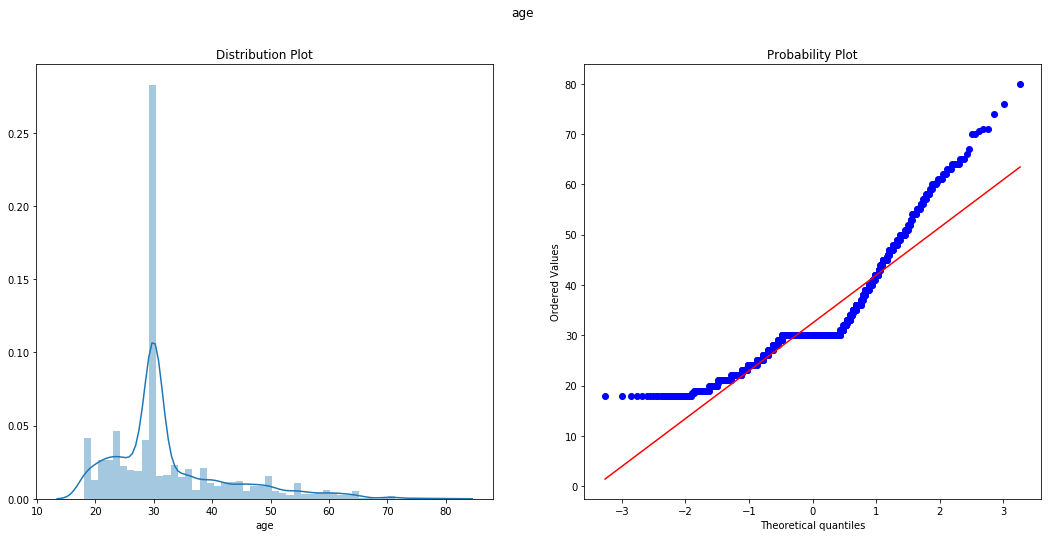

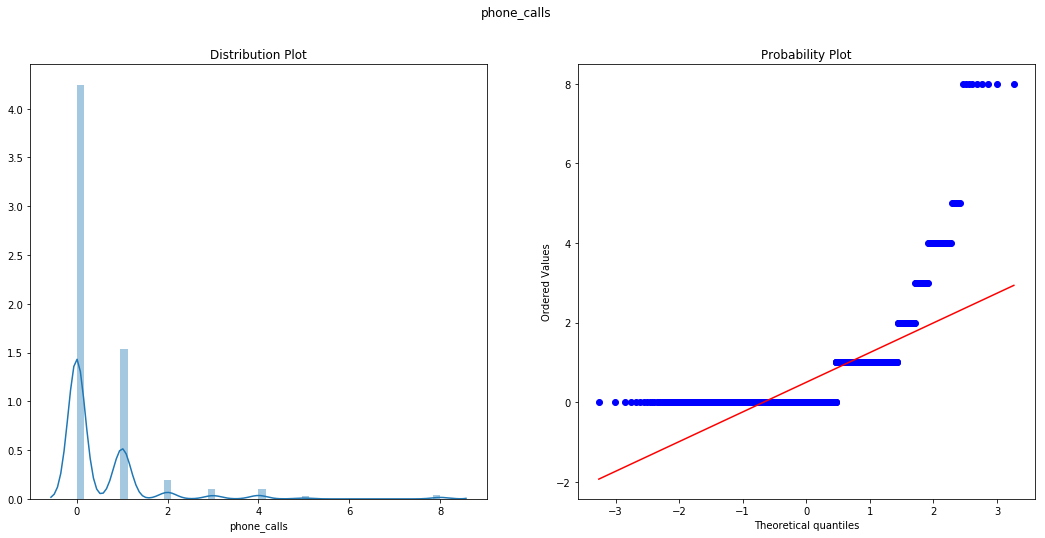

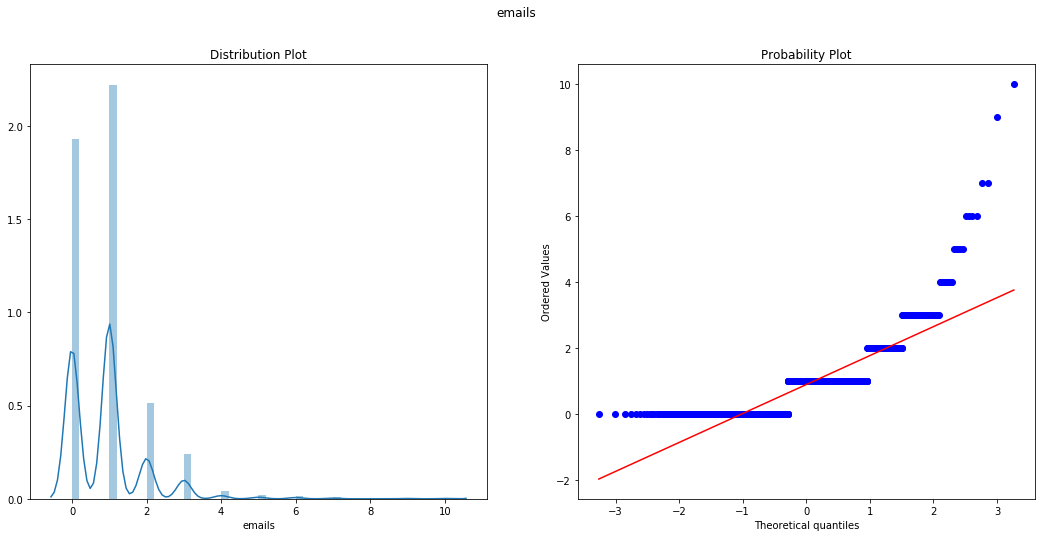

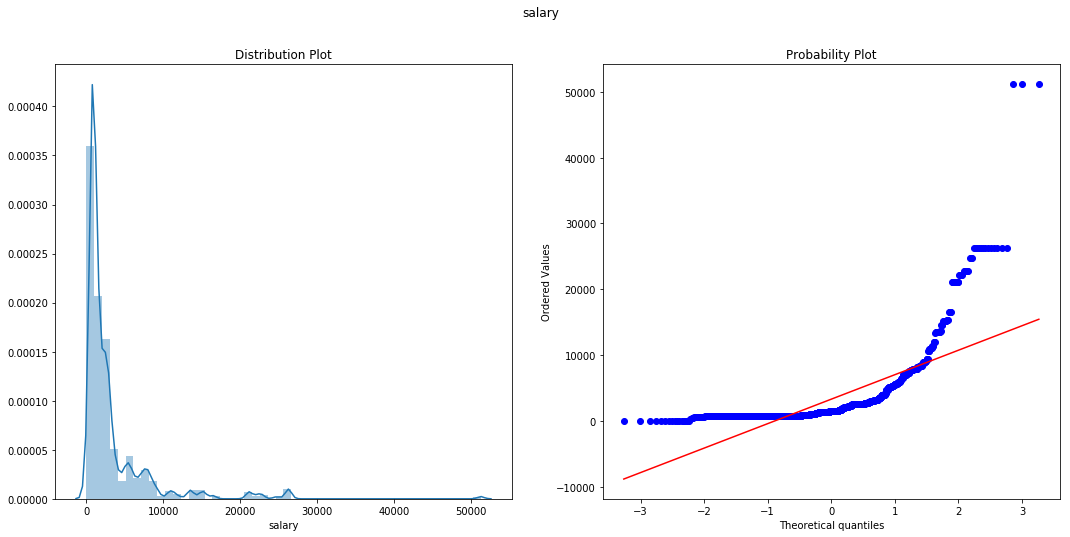

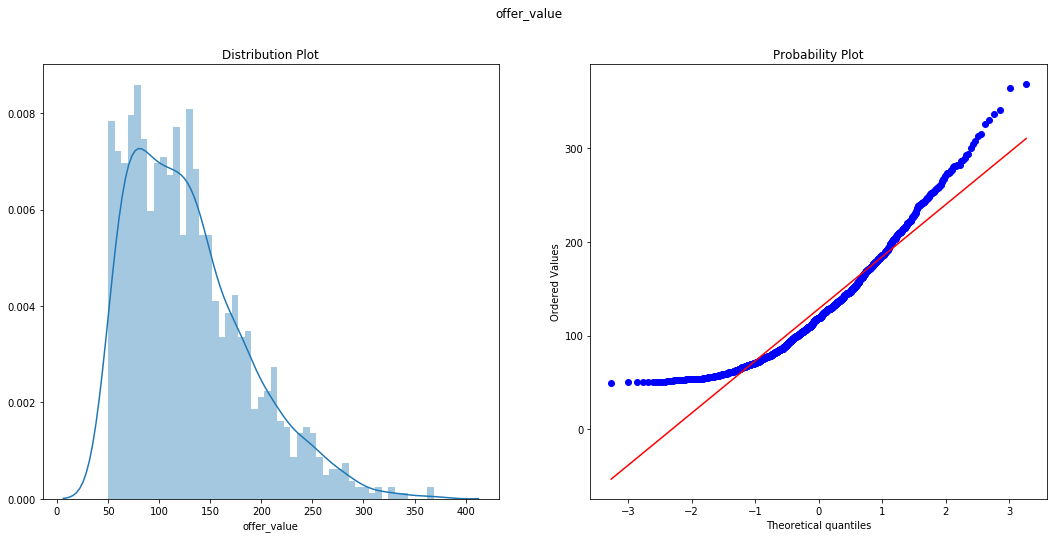

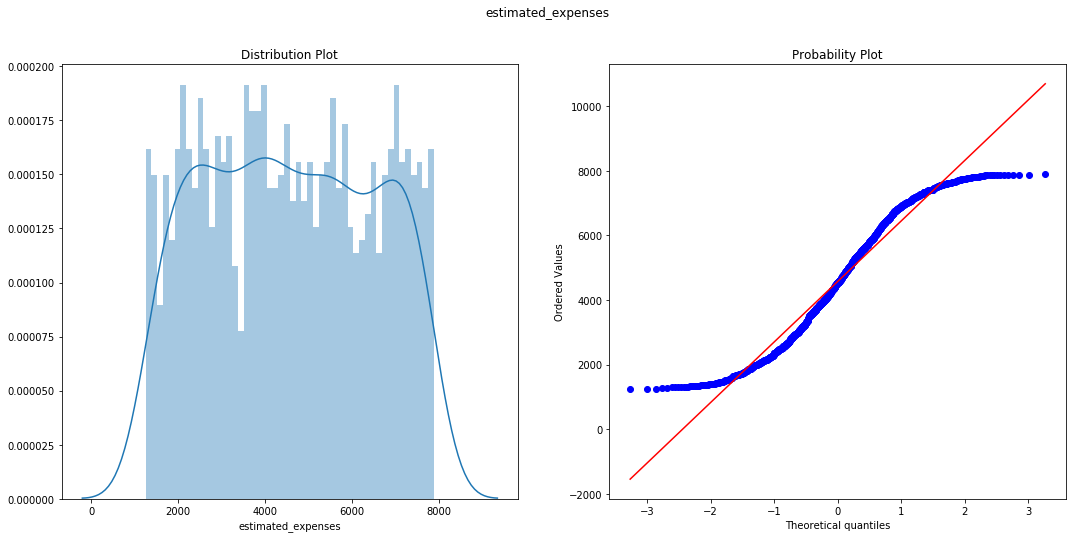

In [139]:
n = len(df_num)
for column in df_num:
    # Distribution
    fig = plt.figure(figsize=(18, 8))
    fig.suptitle(column)
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Distribution Plot')
    sns.distplot(df_num[column], bins=50, hist_kws={'alpha': 0.4}) 

    # QQ-plot
    ax2 = fig.add_subplot(122)
    stats.probplot(df_num[column], plot=plt, dist='norm')
    plt.show();

In [60]:
df_num['offer_value']

0        57.426571
1       141.639912
2       154.821130
3       106.256196
4       139.237147
5        62.169773
6        60.742667
7       289.613239
8        75.369051
9       102.144904
10      128.277347
11      161.352318
12       87.760293
13       58.312947
14       87.717730
15      154.593613
16      172.304627
17      203.472922
18      162.987764
19       68.472646
20       85.559777
21      142.918433
22      110.021422
23      212.229544
24       52.216582
25       91.779684
26      181.884562
27      276.642656
28       93.617746
29      113.493852
           ...    
1279    203.048177
1280     56.735861
1281     66.961232
1282    161.206682
1283    207.009690
1284     77.173849
1285    111.039024
1286    279.939916
1287    123.290555
1288    165.075347
1289    118.645478
1290    118.645478
1291    118.645478
1292    118.645478
1293    118.645478
1294    118.645478
1295    118.645478
1296    118.645478
1297    118.645478
1298    118.645478
1299    118.645478
1300    118.

In [69]:
# BoxCox: This will not work for all num variables as BoxCox requires values > 0 (only age conforms this)
def normalize_num_features(df, columns = []):
    # This will not work for all num variables as BoxCox requires values > 0 (only age conforms this)
    df_num_normalized = pd.DataFrame()
    n = len(df)

    df_num = pd.DataFrame()
    df_num[columns] = df[columns]

    for column in df_num:

        # Distribution
        fig = plt.figure(figsize=(18, 8))

        ax1 = fig.add_subplot(221)
        ax1.title.set_text('Distribution Plot')
        sns.distplot(df_num[column], bins=50, hist_kws={'alpha': 0.4}) 

        # QQ-plot
        ax2 = fig.add_subplot(222)
        stats.probplot(df_num[column], plot=plt, dist='norm')

        # Box-Cox Transformation
        # http://www.kmdatascience.com/2017/07/box-cox-transformations-in-python.html
        transform = np.asarray(df[[column]].values)
        dft = stats.boxcox(transform)[0]
        df_num_normalized[column] = pd.Series(dft.ravel())

        ax3 = fig.add_subplot(223)
        ax3.title.set_text('Normalized Distribution Plot')
        sns.distplot(dft, bins=50, hist_kws={'alpha': 0.4})

        ax4 = fig.add_subplot(224)
        ax4.title.set_text('')
        stats.probplot(df_num_normalized[column], plot=plt, dist='norm')

        plt.tight_layout()
        plt.show();

        n_unique = len(df_num[column].unique())
        print('Feature: {}'.format(column))
        print('Enique values count: {}'.format(n_unique))
        print('Unique values ratio: {}'.format(n_unique / n))
        print('Missing values ratio: {}'.format(df_num[column].isnull().sum() / n))
        print('Median: {}'.format(df_num[column].median()))
        print('------------------------------------')

        print()
        
    return df_num_normalized

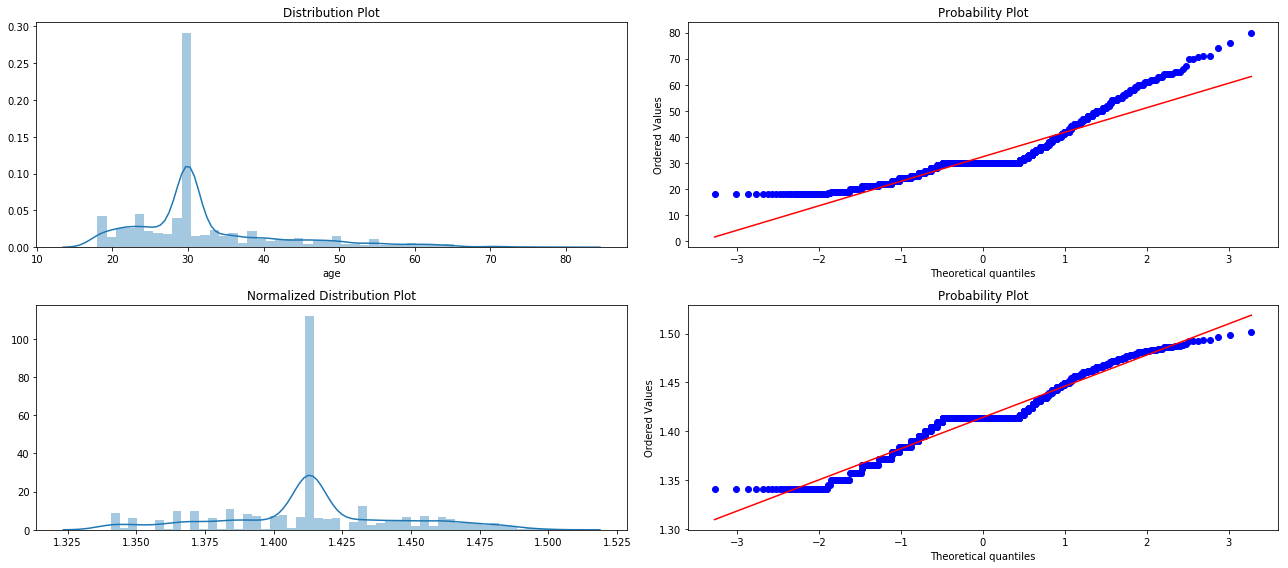

Feature: age
Enique values count: 72
Unique values ratio: 0.05500381970970206
Missing values ratio: 0.0
Median: 30.0
------------------------------------



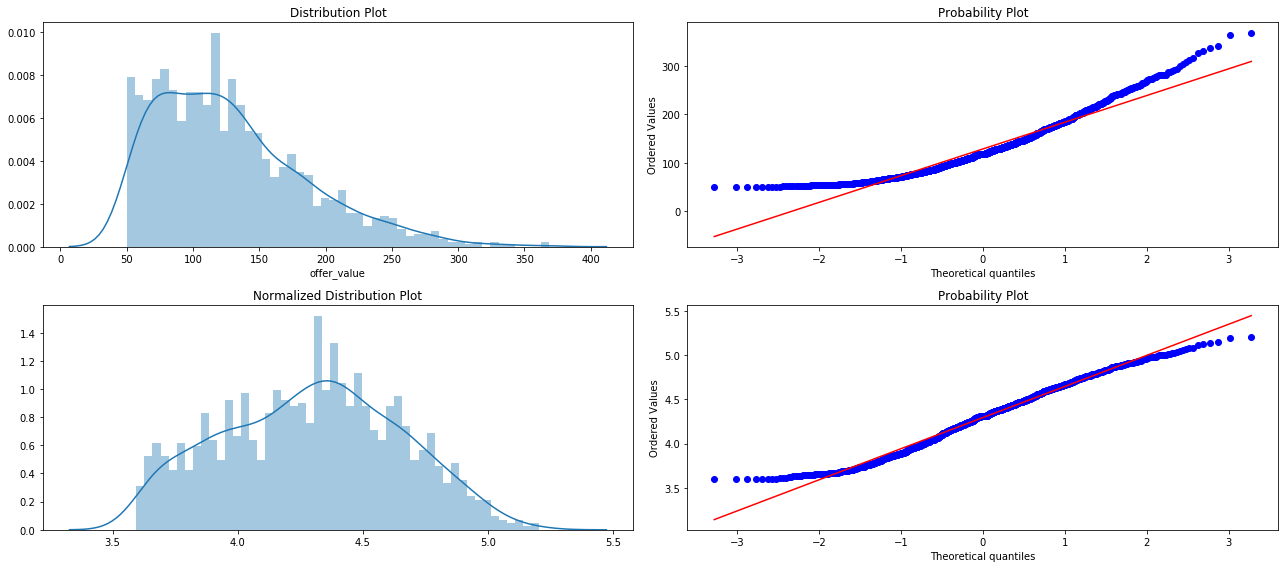

Feature: offer_value
Enique values count: 1277
Unique values ratio: 0.975553857906799
Missing values ratio: 0.0
Median: 118.6454777
------------------------------------



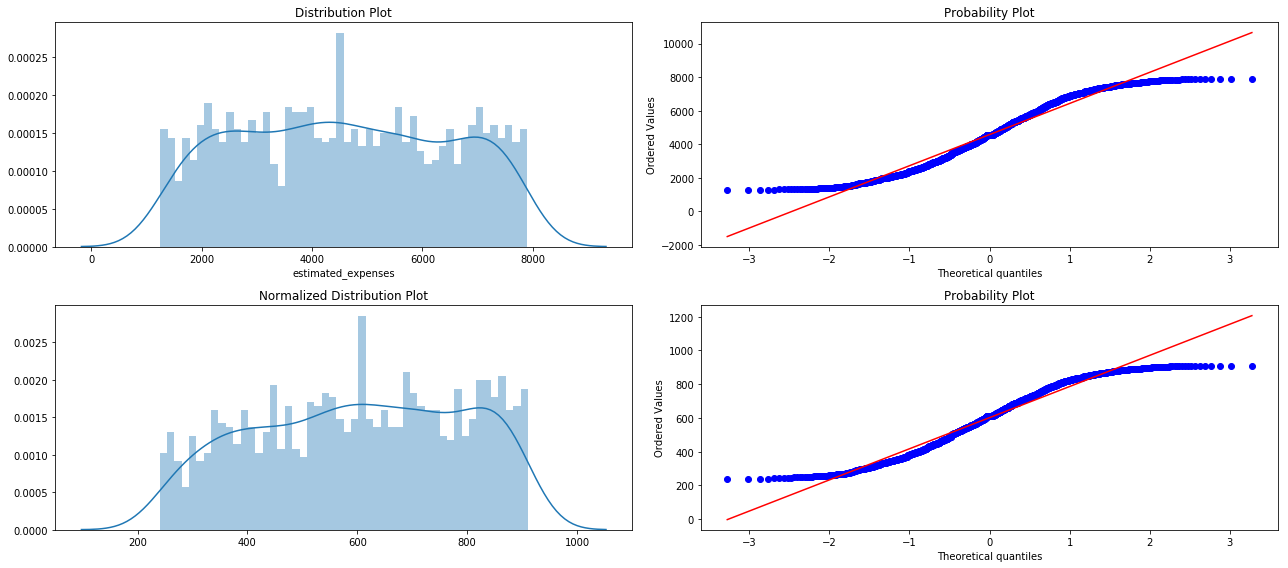

Feature: estimated_expenses
Enique values count: 1186
Unique values ratio: 0.906035141329259
Missing values ratio: 0.0
Median: 4544.0
------------------------------------



In [70]:
df_num_normalized = normalize_num_features(df_num, columns = ['age', 'offer_value', 'estimated_expenses'])

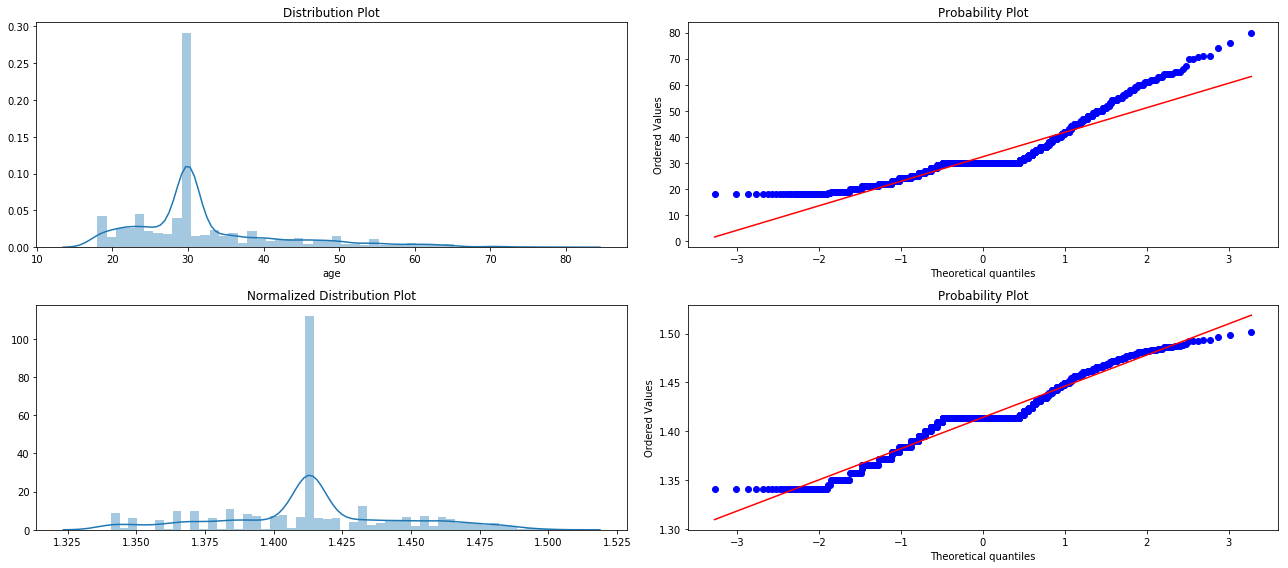

Feature: age
Enique values count: 72
Unique values ratio: 0.05500381970970206
Missing values ratio: 0.0
Median: 30.0
------------------------------------



ValueError: Data must be positive.

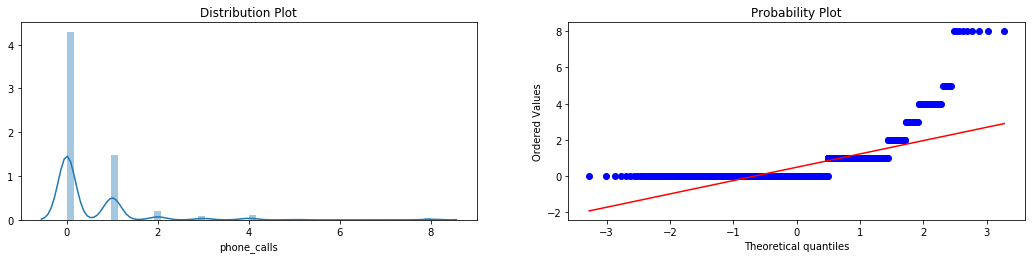

In [43]:
# This will not work for all num variables as BoxCox requires values > 0 (only age conforms this)
df_num_normalized = pd.DataFrame()
n = len(df_num)

df_num2 = pd.DataFrame()
df_num2[['age', 'offer_value', 'estimated_expenses']] = df_num[['age', 'offer_value', 'estimated_expenses']]

for column in df_num:
    
    # Distribution
    fig = plt.figure(figsize=(18, 8))

    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Distribution Plot')
    sns.distplot(df_num[column], bins=50, hist_kws={'alpha': 0.4}) 

    # QQ-plot
    ax2 = fig.add_subplot(222)
    stats.probplot(df_num[column], plot=plt, dist='norm')

    # Box-Cox Transformation
    # http://www.kmdatascience.com/2017/07/box-cox-transformations-in-python.html
    transform = np.asarray(df[[column]].values)
    dft = stats.boxcox(transform)[0]
    df_num_normalized[column] = pd.Series(dft.ravel())
    
    ax3 = fig.add_subplot(223)
    ax3.title.set_text('Normalized Distribution Plot')
    sns.distplot(dft, bins=50, hist_kws={'alpha': 0.4})

    ax4 = fig.add_subplot(224)
    ax4.title.set_text('')
    stats.probplot(df_boxcox[column], plot=plt, dist='norm')

    plt.tight_layout()
    plt.show();
    
    n_unique = len(df_num[column].unique())
    print('Feature: {}'.format(column))
    print('Enique values count: {}'.format(n_unique))
    print('Unique values ratio: {}'.format(n_unique / n))
    print('Missing values ratio: {}'.format(df_num[column].isnull().sum() / n))
    print('Median: {}'.format(df_num[column].median()))
    print('------------------------------------')
    
    print()

In [ ]:
df3 = pd.DataFrame()
#df3['age'] = dft.tolist()
df3

In [ ]:
df3['age'] = pd.Series(dft.ravel())
df3['age']

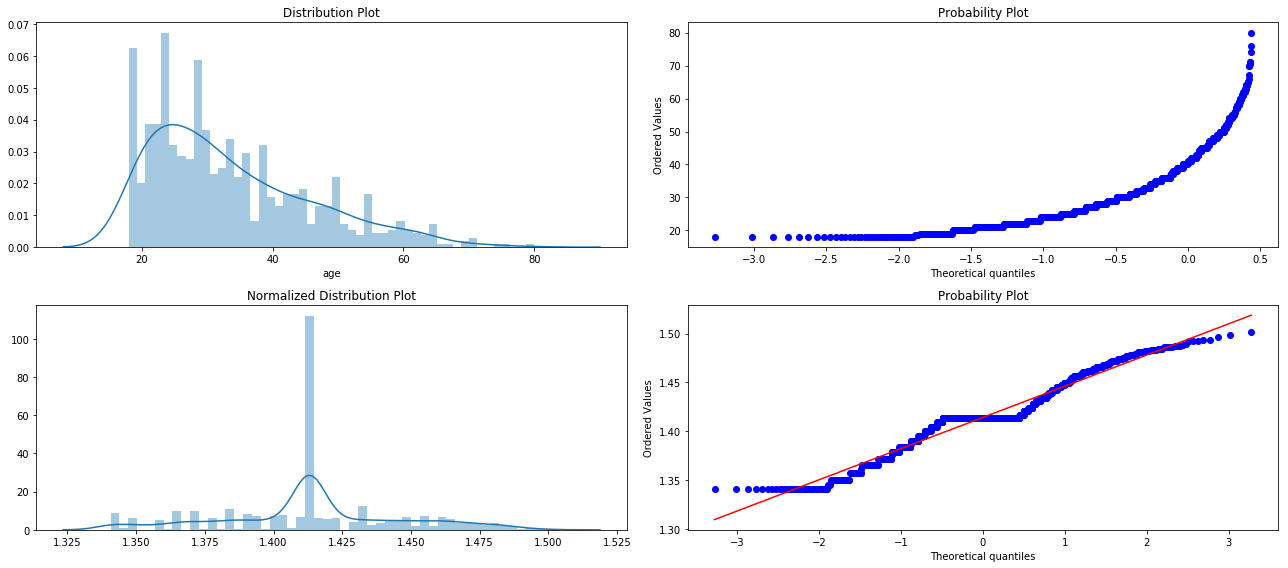

In [30]:
column = 'age'
df_boxcox = pd.DataFrame()

#http://www.kmdatascience.com/2017/07/box-cox-transformations-in-python.html

# Distribution
fig = plt.figure(figsize=(18, 8))
#fig.suptitle(column)

ax1 = fig.add_subplot(221)
ax1.title.set_text('Distribution Plot')
sns.distplot(df_num[column], bins=50, hist_kws={'alpha': 0.4}) 

# QQ-plot
ax2 = fig.add_subplot(222)
stats.probplot(df_num[column], plot=plt, dist='norm')
#ax2.margins(0.5)

# Box-Cox Transformation
ax3 = fig.add_subplot(223)
ax3.title.set_text('Normalized Distribution Plot')
transform = np.asarray(df[[column]].values)
dft = stats.boxcox(transform)[0]
sns.distplot(dft, bins=50, hist_kws={'alpha': 0.4})

ax4 = fig.add_subplot(224)
df_boxcox[column] = pd.Series(dft.ravel())
ax4.title.set_text('')
stats.probplot(df_boxcox[column], plot=plt, dist='norm')

plt.tight_layout()
plt.show()

In [ ]:

df_num.plot(kind='density', subplots=True, layout=(2,8), sharex=False, legend=False, fontsize=1)
plt.show();

In [ ]:
# box and whisker plots
df_num.plot(kind='box', subplots=True, sharex=False, sharey=False, fontsize=1)
plt.show()

- attributes do have quite different spreads. Given the scales are the same, it may suggest some benefit in standardizing the data for modeling to get all of the means lined up.

In [ ]:
# box and whisker plots
df_num_normalized.plot(kind='box', subplots=True, sharex=False, sharey=False, fontsize=1)
plt.show()

In [ ]:
df.corr()

In [ ]:
# correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr(), vmin=-1, vmax=1, interpolation='none') 
fig.colorbar(cax)
plt.show();

In [ ]:
def correlated_columns(df, min_corr_level=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > min_corr_level)]
    return to_drop

In [ ]:
columns_to_drop = correlated_columns(df)
columns_to_drop

In [ ]:
# Standardize data

In [ ]:
# Split-out validation dataset
array = dataset.values
X = array[:,0:60].astype(float)
Y = array[:,60]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
    test_size=validation_size, random_state=seed)

In [ ]:
### Correlations!!!